In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "/content/drive/MyDrive/DatasetGFT"
ACTIVITY_LABELS = [0, 1, 2, 3, 4, 5]
ACTIVITY_NAMES = [
    "Rest",
    "Fold clothes",
    "Sweep",
    "Walk",
    "Move boxes",
    "Bike"
]

SAMPLING_RATE = 100
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_enu", "ay_enu", "az_enu", "gx_enu", "gy_enu", "gz_enu"]

In [13]:
def load_gft_csvs(base_dir):
    subject_dfs = {}

    for subject_id in sorted(os.listdir(base_dir)):
        subject_path = os.path.join(base_dir, subject_id)
        if not os.path.isdir(subject_path):
            continue

        csv_files = glob.glob(
            os.path.join(subject_path, "IMU_GFT_*.csv")
        )

        if len(csv_files) == 0:
            continue

        subject_dfs[subject_id] = pd.read_csv(csv_files[0])

    print(f"Loaded {len(subject_dfs)} subjects")
    return subject_dfs

In [14]:
def split_subjects_60_20_20(subject_dfs):
    subjects = list(subject_dfs.keys())
    np.random.shuffle(subjects)

    n_total = len(subjects)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)

    train_subjects = subjects[:n_train]
    val_subjects = subjects[n_train:n_train + n_val]
    test_subjects = subjects[n_train + n_val:]

    print(f"Train subjects: {len(train_subjects)}")
    print(f"Val subjects:   {len(val_subjects)}")
    print(f"Test subjects:  {len(test_subjects)}")

    return (
        [subject_dfs[s] for s in train_subjects],
        [subject_dfs[s] for s in val_subjects],
        [subject_dfs[s] for s in test_subjects]
    )

In [15]:
def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]


def extract_features(window, cols):
    feats = []
    for c in cols:
        x = window[c].values

        # Time-domain
        feats.extend([
            np.mean(x), np.std(x),
            np.min(x), np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.mean(np.abs(x))
        ])

        # Frequency-domain
        fft_vals = np.fft.rfft(x)
        fft_mag = np.abs(fft_vals)
        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])

    return feats


def build_dataset(dfs, feature_cols):
    X, y = [], []

    for df in dfs:
        missing = set(feature_cols + ["label"]) - set(df.columns)
        assert not missing, f"Missing columns: {missing}"

        df = df[feature_cols + ["label"]]

        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["label"].iloc[0])

    return np.array(X), np.array(y)

In [21]:
def balance_classes_undersample(X, y, random_state=42):
    np.random.seed(random_state)

    X_balanced = []
    y_balanced = []

    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    print("Class counts before balancing:")
    for c, cnt in zip(classes, counts):
        print(f"  Class {c}: {cnt}")

    for cls in classes:
        idx = np.where(y == cls)[0]
        selected_idx = np.random.choice(idx, size=min_count, replace=False)

        X_balanced.append(X[selected_idx])
        y_balanced.append(y[selected_idx])

    X_balanced = np.vstack(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    perm = np.random.permutation(len(y_balanced))
    X_balanced = X_balanced[perm]
    y_balanced = y_balanced[perm]

    print(f"\nBalanced each class to {min_count} samples")

    return X_balanced, y_balanced

In [19]:
def select_knn_on_validation(X_train, y_train, X_val, y_val):
    params = {
        "n_neighbors": 7,
        "weights": "distance",
        "metric": "euclidean"
    }

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(**params))
    ])

    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)

    f1 = f1_score(y_val, y_val_pred, average="macro")

    print("Using fixed parameters:", params)
    print(f"Validation F1: {f1:.4f}")

    return params


In [17]:
def evaluate_on_test(X_train, y_train, X_test, y_test, best_params, title):
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(**best_params))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n=== {title} ===")
    print(classification_report(
        y_test, y_pred,
        target_names=ACTIVITY_NAMES,
        digits=4
    ))

    cm = confusion_matrix(y_test, y_pred, labels=ACTIVITY_LABELS)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=ACTIVITY_NAMES,
        yticklabels=ACTIVITY_NAMES,
        cmap="Blues"
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro")
    }

Loaded 60 subjects
Train subjects: 36
Val subjects:   12
Test subjects:  12
Class counts before balancing:
  Class 0.0: 24664
  Class 1.0: 10912
  Class 2.0: 10472
  Class 3.0: 10638
  Class 4.0: 10424
  Class 5.0: 10757

Balanced each class to 10424 samples
Using fixed parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}
Validation F1: 0.6268

=== KNN – Raw IMU Frame ===
              precision    recall  f1-score   support

        Rest     0.7258    0.5510    0.6264      7978
Fold clothes     0.5124    0.6052    0.5550      3582
       Sweep     0.5009    0.5622    0.5298      3529
        Walk     0.6341    0.6805    0.6565      3537
  Move boxes     0.7188    0.7013    0.7099      3488
        Bike     0.6426    0.7710    0.7010      3332

    accuracy                         0.6276     25446
   macro avg     0.6224    0.6452    0.6298     25446
weighted avg     0.6400    0.6276    0.6283     25446



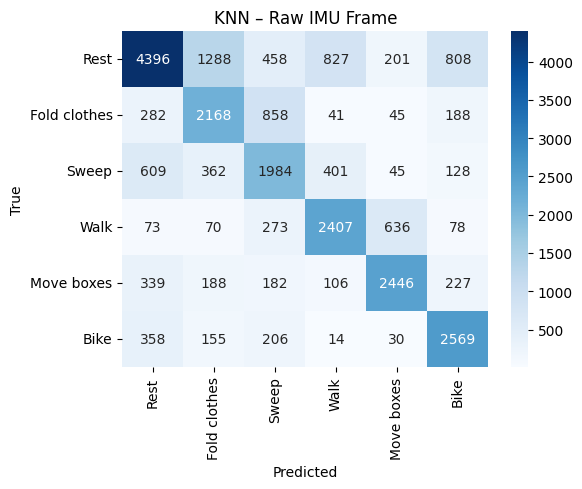

Class counts before balancing:
  Class 0.0: 24664
  Class 1.0: 10912
  Class 2.0: 10472
  Class 3.0: 10638
  Class 4.0: 10424
  Class 5.0: 10757

Balanced each class to 10424 samples
Using fixed parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}
Validation F1: 0.6352

=== KNN – Global Frame (ENU) ===
              precision    recall  f1-score   support

        Rest     0.7017    0.5641    0.6254      7978
Fold clothes     0.5385    0.5625    0.5502      3582
       Sweep     0.3719    0.4398    0.4030      3529
        Walk     0.6076    0.5980    0.6027      3537
  Move boxes     0.6156    0.5757    0.5950      3488
        Bike     0.4896    0.6429    0.5559      3332

    accuracy                         0.5632     25446
   macro avg     0.5541    0.5638    0.5554     25446
weighted avg     0.5803    0.5632    0.5675     25446



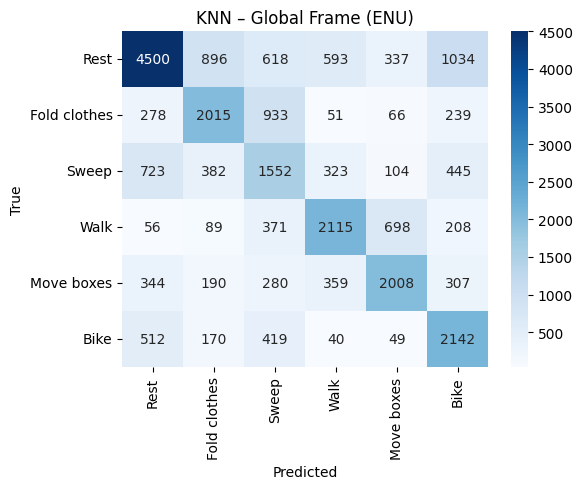


========== SUMMARY ==========
Raw Frame: {'precision': 0.6224168687776918, 'recall': 0.6452087943214022, 'f1': 0.62975504526853}
Global Frame: {'precision': 0.554142292143368, 'recall': 0.5638133786209973, 'f1': 0.5553676561694934}


In [22]:
if __name__ == "__main__":
    subject_dfs = load_gft_csvs(DATA_DIR)
    train_dfs, val_dfs, test_dfs = split_subjects_60_20_20(subject_dfs)

    X_train_raw, y_train_raw = build_dataset(train_dfs, RAW_FEATURES)
    X_train_raw, y_train_raw = balance_classes_undersample(
        X_train_raw, y_train_raw
    )
    X_val_raw, y_val_raw = build_dataset(val_dfs, RAW_FEATURES)
    X_test_raw, y_test_raw = build_dataset(test_dfs, RAW_FEATURES)
    best_raw_params = select_knn_on_validation(
        X_train_raw, y_train_raw,
        X_val_raw, y_val_raw
    )
    raw_metrics = evaluate_on_test(
        X_train_raw, y_train_raw,
        X_test_raw, y_test_raw,
        best_raw_params,
        "KNN – Raw IMU Frame"
    )

    X_train_gft, y_train_gft = build_dataset(train_dfs, GFT_FEATURES)
    X_train_gft, y_train_gft = balance_classes_undersample(
        X_train_gft, y_train_gft
    )
    X_val_gft, y_val_gft = build_dataset(val_dfs, GFT_FEATURES)
    X_test_gft, y_test_gft = build_dataset(test_dfs, GFT_FEATURES)
    best_gft_params = select_knn_on_validation(
        X_train_gft, y_train_gft,
        X_val_gft, y_val_gft
    )
    gft_metrics = evaluate_on_test(
        X_train_gft, y_train_gft,
        X_test_gft, y_test_gft,
        best_gft_params,
        "KNN – Global Frame (ENU)"
    )

    print("\n========== SUMMARY ==========")
    print("Raw Frame:", raw_metrics)
    print("Global Frame:", gft_metrics)
